# Introduction

In this document, we will try to understand a few things about network
reception within the kernel:

* The first goal is to have an idea on the reception capacity: what is
  the time needed by the kernel to route a UDP skbuf structure to the
  related socket ?
* The second goal is to find out the parameters which make this delay
  change: is the message size relevant ? Should we care about multi-core
  ?
  
In this first part of the document, let's focus on a simple system (no
multi-core) and a simple benchmark (netperf's UDP_STREAM). Let's stay
simple as much as possible. We do not want to dive into the
specifities and performances of a protocol implementation, we want to
get an idea on the network stack infrastructure's capabilities, let's
use a simple protocol: UDP.

# Description of the test environment

Because of a lack of suitable hardware (I just have a 3 years old Dell
XPS-13 laptop), I had to use a virtual machine to get a NAPI-compliant
device.

Here are some details on the host machine (basic laptop machine):

* CPU: Intel Core i7-3537U @ 2.00GHz (up to 3.10GHz) 1 CPU / 2 cores
  per CPU / 2 threads per core;
* RAM: 8GB;
* System: Arch (linux-4.5.4.1, glibc-2.23)
* Cpufreq governor: performance: the pstate power scaling driver is
  used; so the CPU frequency cannot be statically set with a
  user-space tool.
```
# cpupower frequency-set -g performance
```

Here are some details on the guest machine (Qemu/KVM):

* CPU: 2 emulated/virtualized cores
* RAM: 3GB
* System: generated with buildroot (linux-4.6.0, glibc-2.23,
  busybox-1.24.2 and integrated as an initramfs into the kernel);
* Command line:
```
# qemu-system-x86_64 \
    -enable-kvm -cpu host \
    -m 3G \
    -nographic -append "console=ttyS0,9600n8" \
    -netdev tap,id=t0,script=no,downscript=no -device virtio-net,netdev=t0 \
    -kernel bzImage
```

The tool "perf" was needed for the benchmarks; unfortunately,
buildroot does not support perf's script facilities (more precisely
python) and disables it at compile time. The buildroot related
Makefile was modified so as to enable python scripting; a diff is
available in annex A.

# Some more details on the network configurations

Here is the chosen network configuration:

* The selected Qemu internal network device is the para-virtualized
  nic virtio-net; the device was not closely studied but I assume it
  prevents a copy thanks to some ring-buffer;
* Qemu uses a tap interface to communicate with the host OS.

The reader will find in annex B some basic stuff to configure the
interfaces.

One last point regarding Qemu and network can be easily unveiled
during intensive packet transfers (from the host OS to the guest OS)
thanks to pidstat:
  
```
[alexis@marx-slim tmp_public]$ sudo pidstat -p `pidof qemu-system-x86_64` -t 1
Linux 4.5.4-1-ARCH (marx-slim)  06/02/2016      _x86_64_        (4 CPU)

10:50:35 AM   UID      TGID       TID    %usr %system  %guest    %CPU   CPU  Command
10:50:36 AM     0      6869         -   71.00   41.00   87.00  100.00     1  qemu-system-x86
10:50:36 AM     0         -      6869   70.00   29.00    0.00   99.00     1  |__qemu-system-x86
10:50:36 AM     0         -      6870    0.00    0.00    0.00    0.00     0  |__qemu-system-x86
10:50:36 AM     0         -      6874    0.00   12.00   87.00   99.00     0  |__qemu-system-x86
```

The command above displays threads activities within Qemu; the reader
will notice that the last thread (tid:6874) is in charge of running
the emulated/virtualized core and that the first thread (tid: 6869) is
running the code in charge of transfering the packets from the tap
interface into the virtio ring-buffer.

The first interesting point, here, is that both threads are consuming
100% of their core; so, both threads can be considered as
bottlenecks. The second point is that the filling of the virtio
ring-buffer and its emptying are not sequentially but concurrently.

# Description of the benchmark procedure

The idea is very basic:

* Use netperf's UDP_STREAM benchmark and...
* Use static tracepoints to understand the dynamic behaviours, delays,
  etc.

In this first part of the theme, there is only 1 benchmark:

* A client application (netperf located on the host machine) sends as
  many UDP packets as possible to...
  the VM.
* ...the netserver application located inside the VM.
* With this configuration, we want to monitor and assess the Linux
  kernet's network reception behaviour.

Here is a diagram of the whole picture:

```
 Host machine
+----------------------------------------------------------------------------------------+
|                                                                                        |
|  +----------------------------------------------------------------------------------+  |
|  |                       Host kernel with a tap interface up                        |  |
|  |                                                                                  |  |
|  +----------------------------------------------------------------------------------+  |
|                                                                                        |
|                                     +-----------------------------------------------+  |
|                                     | Guest machine (Qemu / KVM)                    |  |
|                                     | +-------------------------------------------+ |  |
|                                     | | Guest kernel with virtio-net interface up | |  |
|                                     | |                                           | |  |
|                                     | +-------------------------------------------+ |  |
|                                     |                                               |  |
|                                     |                                               |  |
|  +-----------------------+          |             +----------------------+          |  |
|  |                       | TCP control connection |                      |          |  |
|  |                       | XXXXXXXXXXXXXXXXXXXXXX |                      |          |  |
|  |                       |          |             |                      |          |  |
|  |   User application    |          |             |   User application   |          |  |
|  |   "netperf" using     | UDP large packets flow |   "netserver" using  |          |  |
|  |   the tap interface   | XXXXXXXXXXXXXXXXXXXXXX |   the virtio-net     |          |  |
|  |                       | XXXXXXXXXXXXXXXXXXXXXX |   interface          |          |  |
|  |                       | XXXXXXXXXXXXXXXXXXXXXX |                      |          |  |
|  |                       | XXXXXXXXXXXXXXXXXXXXXX |                      |          |  |
|  +-----------------------+          |             +----------------------+          |  |
|                                     |                                               |  |
|                                     |                                               |  |
|                                     +-----------------------------------------------+  |
+----------------------------------------------------------------------------------------+
```

This configuration was run twice: a first time without tracepoint and
a second one with tracepoints enabled.

Here is the list tracepoints enabled:
* All the irq-related tracepoints (irq:irq_handler_entry,
  irq:softirq_raise, etc.)
* All the sched-related tracepoints (sched:sched_wakeup,
  sched:sched_switch, etc.)
* All the exceptions-related tracepoints (exceptions:page_fault_user,
  etc.)
* Some network-related tracepoints (napi__napi_poll and
  net__netif_receive_skb).

The reader will find in annex C the whole perf command and a list of
all the recorded tracepoints during the tests.

As the guest system is just a buildroot-build initramfs image, it was
necessary to export the perf archive (containing the tracepoint
events) into the host OS.

So a python script (executed by perf) was used so as to convert the
perf archive into a csv file. Then, the csv file was copied on the
host machine and I could manipulate its content with Pandas (that is
why I needed buildroot to build a perf tool which supported python
scripting).

The reader will find in annex C the perf command line which did this
job and where the python script comes from a github project named
[linux-perf-stats](https://github.com/aberlemont/linux-perf-stats).

There is one more point to take into account: the cost of the
tracepoint. In a
[former benchmark]((http://nbviewer.ipython.org/urls/raw.github.com/aberlemont/notes-on-linux-and-performance/master/perf/cost_of_tracepoints_and_probes_part1.ipynb)),
the cost of a static tracepoint was calculated: 350ns per event.

In all the document, the timestamps in pandas dataframes were not
modified so as to remove the tracepoints overhead. The reader has to
keep in mind the overhead (350ns) and substract it from all the
calculated delays below (unless it is explicitely stated).

# Manipulating the (converted) tracepoints archive

First let's have a look at some parts of the large sample:

In [116]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)
df.loc[df.nsecs >= 2108404020239].head(14)

                 nsecs  cpu                    event  pid       comm
2714252  2108404020239    0   irq__irq_handler_entry  177  netserver
2714253  2108404020664    0       irq__softirq_raise  177  netserver
2714254  2108404021030    0    irq__irq_handler_exit  177  netserver
2714255  2108404021497    0       irq__softirq_entry  177  netserver
2714256  2108404022233    0   net__netif_receive_skb  177  netserver
2714257  2108404023469    0   net__netif_receive_skb  177  netserver
2714258  2108404024509    0   net__netif_receive_skb  177  netserver
2714259  2108404025449    0   net__netif_receive_skb  177  netserver
2714260  2108404026226    0          napi__napi_poll  177  netserver
2714261  2108404026618    0        irq__softirq_exit  177  netserver
2714262  2108404028012    0  raw_syscalls__sys_enter  177  netserver
2714263  2108404030393    0   irq__irq_handler_entry  177  netserver
2714264  2108404030793    0       irq__softirq_raise  177  netserver
2714265  2108404031170    0    irq

With this sample, the reader will get the main steps of the network
reception in Linux:

* Interrupt occurence => IRQ handler execution (all interrupts
  masked): mask the NIC-related interrupt and raise the soft IRQ
  NET_RX.
* Soft IRQ raised => soft IRQ handler execution (only NIC interrupt
  still masked): call driver's napi_poll function which get packets
  from the RX-ring and call netif_receive_skb on each of them.
* The function netif_receive_skb detects and parses the headers (IP +
  UDP) and call the protocol-specific callbacks to process them; the
  packets will end in the appropriate UDP socket queue.
* The user-space which opened the socket triggers a syscall (let's say
  recvmsg or recvmmsg) to pop 1 (or many) packet from the socket queue
  and copy it to user-space.

The tracepoints printed in the dataframe selection above represents
all of these listed steps.

* IRQ handling: irq:irq_handler_entry, irq:irq_handler_exit and
  irq:softirq_raise to defer the execution of NET_RX handler.
* Soft IRQ handling: irq__softirq_entry, irq__softirq_exit,
  net:netif_receive_skb and napi:napi_poll.
* Syscall execution: raw:syscalls__sys_enter.

Let's display the tracepoints events in a timeline.

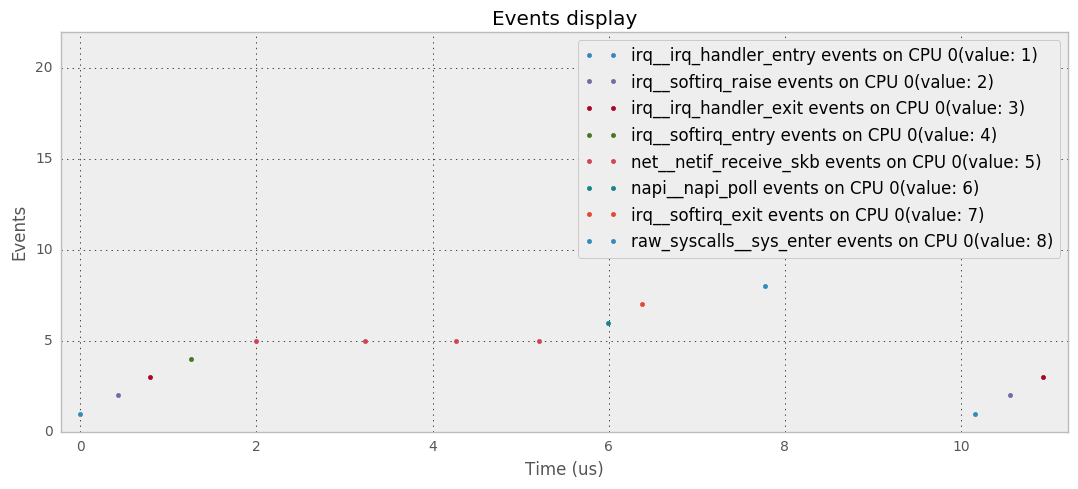

In [146]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)
lps.plot_event_timeline(df, offset=3534945134, delay='11us')

Thanks to the diagram above, we can get a better idea on the timing of
each step:

* IRQ handling: less than 1us (650ns if we remove tracepoint cost);
* Soft IRQ handling: about 5us (4.7us if we remove tracepoint cost);

The reader can even go further: the delay between 2
net:netif_receive_skb events represents the time needed to process 1
packet (here, processing a UDP packet means routing the packets
through the network stack to the proper queue).

So, the reader can deduce that the time needed to process a packet on
the kernel side is about 1.3us. (1us if we remove tracepoint cost). Of
course, we need to analyse the whole pandas dataframe to be sure that
the values are correct.

But before doing that let's see whether we can learn more things with
timelines at different moments of the record (and different scales
too).

Let's have a look at the moment packet reception started in the VM.

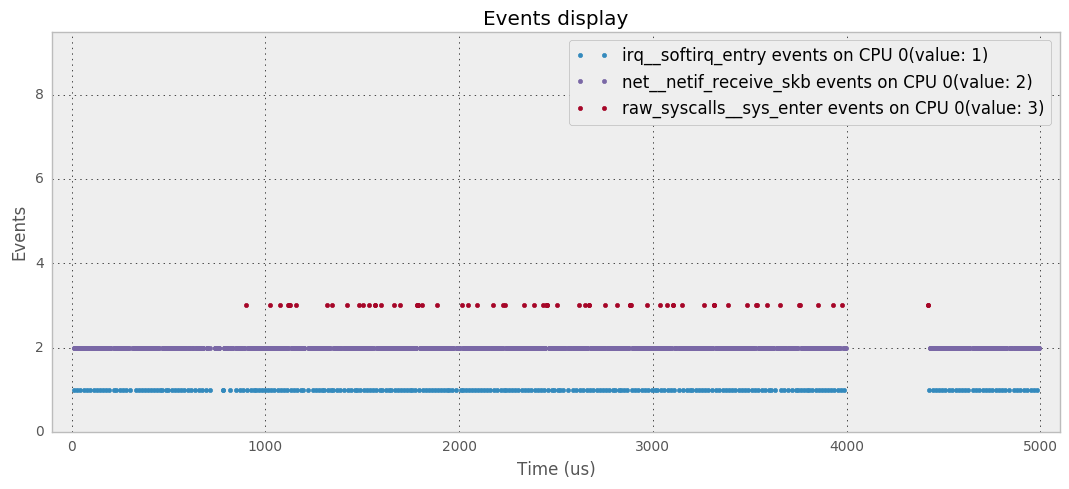

In [137]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)

selected_events = (
    'raw_syscalls__sys_enter',
    'irq__softirq_entry', 'net__netif_receive_skb'
)

selection = df.event.map(lambda x: x in selected_events)
lps.plot_event_timeline(df.loc[selection], offset='990ms', delay='5ms')

This second graphic illustrates what we already saw in the first sample:

* There are far less syscalls (recvmsg) to retrieve packets into
  user-space (and thus remove packets from the socket queue) than
  calls to netif_receive_skb to fill the socket queue.
* Why ? Because IRQs and mechanically soft IRQs systematically preempt
  the user-space application (which is supposed to perform recvmsg
  syscalls).
* Why so many preemptions ? Because the softIRQ occurences frequency
  is high but not high enough to delegate the handling of the softIRQ
  NET_RX to ksoftirqd; if the thread ksoftirqd comes into play (with
  its SCHED_OTHER scheduling policy), there would be a fairer sharing
  of the CPU resources between netserver (which triggers syscalls) and
  ksoftirqd.

If the explanations above are true, we should see that at the end of
the transfer, the user-space application takes some time emptying the
socket queue. The socket depth was set to 2MB; so with 100B packets,
we should notice a significant amount of syscalls after the last call
to netif_receive_skb.

Let's display the last 100ms of the test.

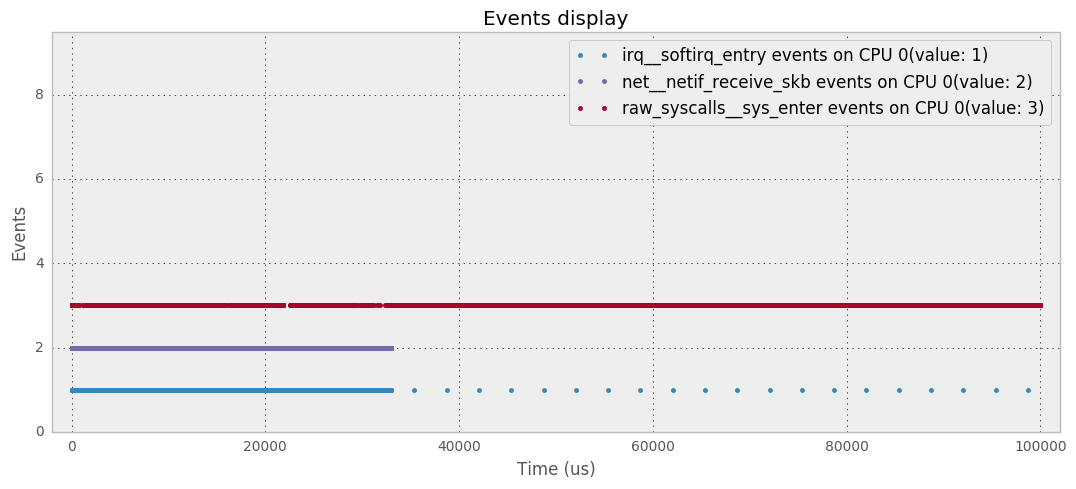

In [138]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)

selected_events = (
    'raw_syscalls__sys_enter',
    'irq__softirq_entry', 'net__netif_receive_skb'
)

selection = df.event.map(lambda x: x in selected_events)

lps.plot_event_timeline(df.loc[selection], offset='3502ms', delay='100ms')

The diagram above clearly shows that:

* Many packets were accumulated into the socket queue;
* The user-space application could not keep the pace because of too
  many preemptions (which fill the queue and potentially drop the
  packets).

## Temporary conclusion

* In a 1-core configuration, the user-space application which reads
  the socket is starving because of systematic preemption caused by
  IRQ (and after soft IRQ).
* On a Ivybridge i7 core (2GHz), the kernel needs at least 1us to take
  a packet from a device RX-ring and bring it to the appropriate
  socket queue.

Starting from here, let's use the python project linux-perf-stats to
calculte delays and processing times.

# Calculating some delays thanks to the (converted) tracepoints archive

Let's print and plot the distribution of delays between 2
netif_receive_skb calls (which correspond to packet processing time on
kernel side).

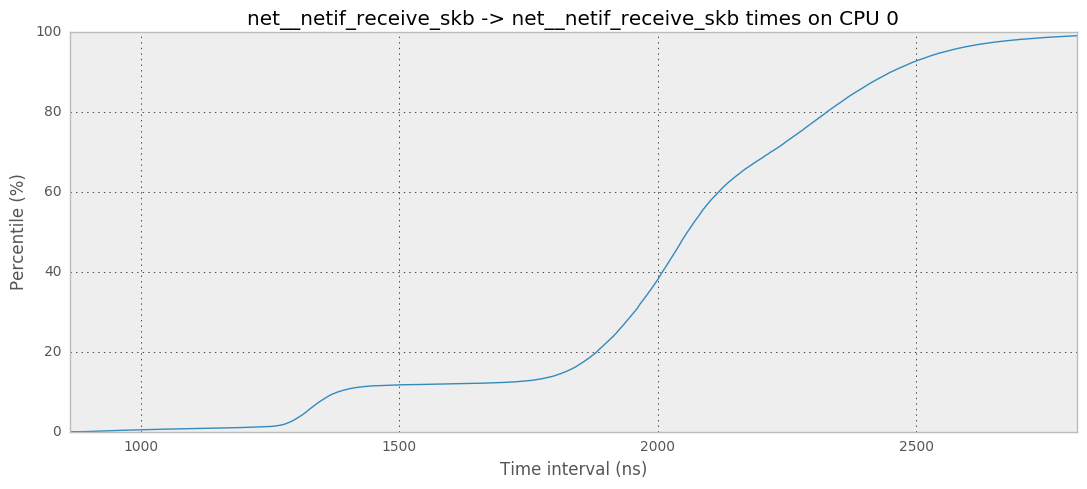

count   473,196.00
mean      2,057.83
std         467.59
min         863.00
25%       1,923.00
50%       2,058.00
75%       2,276.00
max      61,872.00
Name: duration, dtype: float64


Time interval statistics from net__netif_receive_skb to net__netif_receive_skb :
CPU 0


In [23]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)
lps.print_event_intervals(df, 'net__netif_receive_skb', 'net__netif_receive_skb')
lps.plot_event_intervals(df, 'net__netif_receive_skb', 'net__netif_receive_skb')

The results above are a surprise, we expected an average processing
time of 1us (if we remove the tracepoint overhead) but the real value
is nearly the double.

There is an interesting point all the same:

* The percentile diagram displays a step at 1.2us - 1.3us which means
  that a little more than 10% of the process times are worth half of
  the average value.

Before trying to explain this point, let's check that the results
above are accurate; if, most of the time, there is only 1 call to
netif_receive_skb in the soft IRQ handling routine, then the results
cannot be considered as OK.

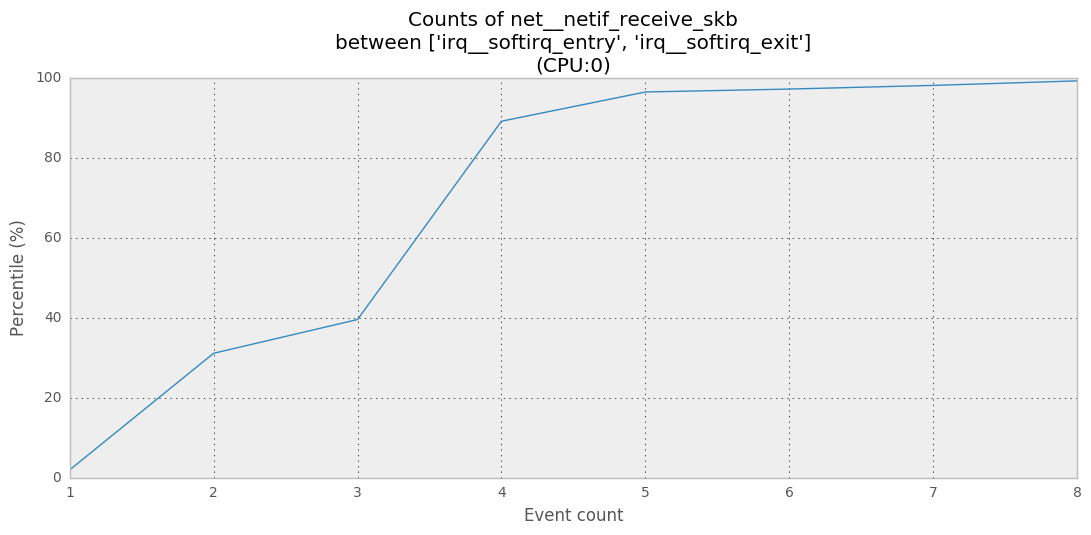

CPU 0
count   187,385.00
mean          3.53
std           2.07
min           1.00
25%           2.00
50%           4.00
75%           4.00
max          64.00
dtype: float64


Counts of events net__netif_receive_skb between the events ['irq__softirq_entry', 'irq__softirq_exit']


In [24]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)
lps.print_event_counts(df, 'net__netif_receive_skb', 'irq__softirq_entry', 'irq__softirq_exit')
lps.plot_event_counts(df, 'net__netif_receive_skb', 'irq__softirq_entry', 'irq__softirq_exit',cpu=0)

The diagram above shows that in 60% of the cases, there were, at
least, 3 calls netif_receive_skb. So, we cannot state, here, that the
delays calculated above are irrelevant.

Next step: let's check that the packet process times do not change
accross time (during the benchmarks which lasted about 3 seconds). The
code below calculates delays between 2 net:netif_receive_skb events
and focuses on the delays between 0 and 3.5us (this is a way of
zooming on the interesting area.

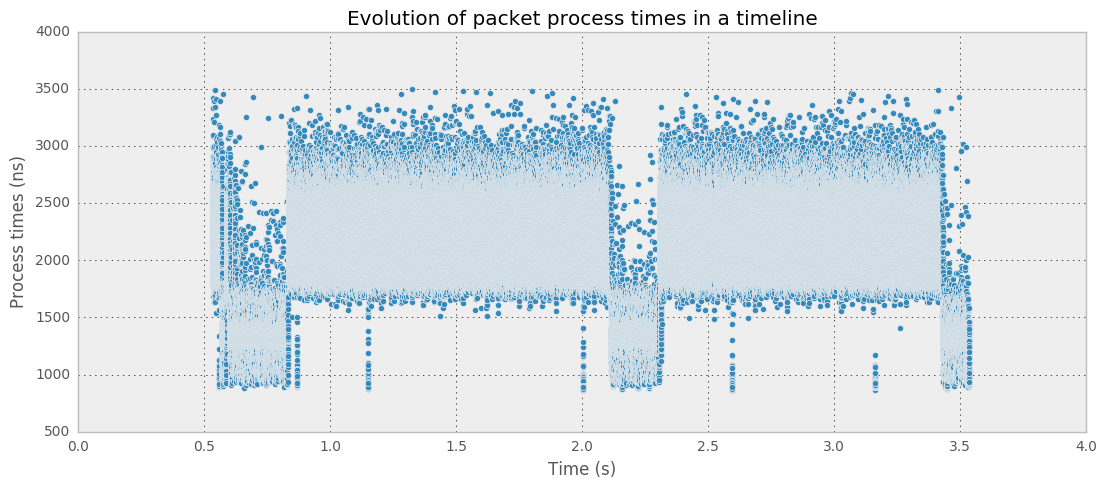

In [25]:
# Create a pandas dataframe starting from the tracepoint archives
# (converted into csv format)
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)
# Let's convert absolute timestamps into relative ones for convenience
df.nsecs -= df.nsecs.iloc[0]
# Let's use an internal function of linux-perf-stats to calculate
# delays between 2 dataframe rows; this function expects a column
# "nsecs" and will create a new column "duration"
df = lps.event_interval._add_intervals(df)
# Select:
# * Only the rows which corresponds to 2 contiguous
#   net:netif_receive_skb events (or dataframe lines)
# * Only the delays below 3.5us so as to zoom on the interesting area
selection = \
    (df.event == 'net__netif_receive_skb') & \
    (df.next_event == 'net__netif_receive_skb') & \
    (df.duration < 3500)
df = df.loc[selection]
# Plot the result:
df['secs'] = df.nsecs / 1e9
plot = df.plot.scatter(x='secs', y='duration')
plot.set_title('Evolution of packet process times in a timeline')
plot.set_ylabel('Process times (ns)')
plot.set_xlabel('Time (s)')

The diagram above unveils a really interesting point: it seems there
are 2 modes or configurations:

* Either the minimal packet process time is about 1us...
* ...or the minimal packet process time is about 1.7us.

The reader will also note that the switches between these 2 modes are
sharp. As a consequence, it is highly probable that the mode switches
are correlated with tasks scheduling. We could even go further: what
could change when a specific thread or task is running ?

* Maybe, the most efficient mode corresponds to the phase when NET_RX
  packet processing is deferred to the thread ksoftirqd because of "a
  high load of soft IRQs"...
* ...or there is some concurrency issue decreasing the performances of
  the NET_RX packet processing.

Next step: analyze the emptying of the socket queue to try to find new
clues.

# A closer look at the syscalls "recv"

Let's have a look at the events raw_syscalls:sys_enter, most of them
should be recvmsg, recvfrom or recv syscalls (maybe with some
select). Let's get the code of netperf and check the code which
receives packets for the benchmark "UDP_STREAM". An extract of the
code (available in annex D) shows that the user-space netserver loops
on the syscall recv (or "recvfrom" which is supposed to be less
efficient according to the comments).

So, by calculating the average delay between 2 syscalls in netserver
application, we can find out the reception throughput to user-space
(in packet per second).

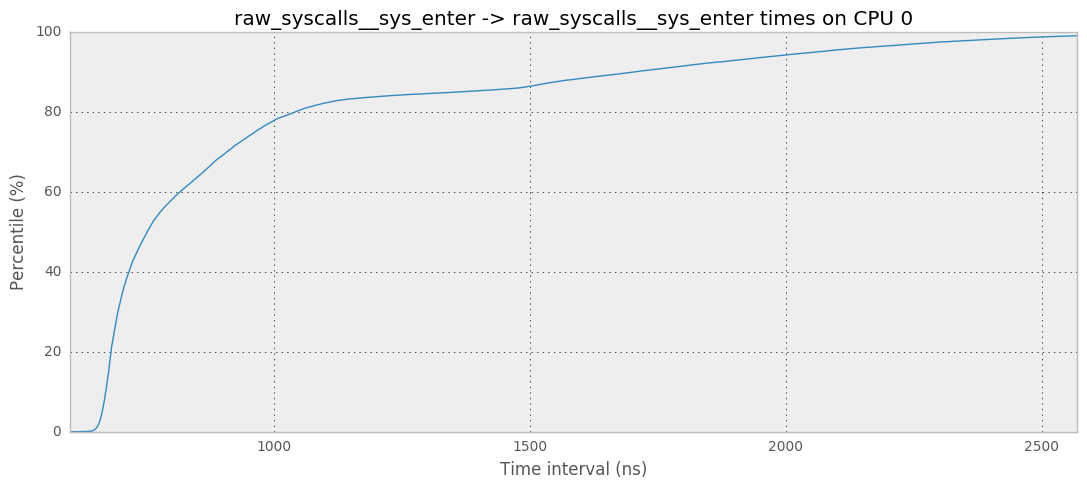

count   56,338.00
mean       958.14
std        479.39
min        602.00
25%        689.00
50%        754.00
75%        965.00
max     27,898.00
Name: duration, dtype: float64


Time interval statistics from raw_syscalls__sys_enter to raw_syscalls__sys_enter :
CPU 0


In [26]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)
df = df.loc[df.comm == 'netserver']
lps.print_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter')
lps.plot_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter')

The average process time is worth 1us which means that, with 1 core,
the Linux kernel is able to send 1 million of packets per second.

There is an annoying point here: the standard deviation nearly reaches
the half of the average value. Let's check with a timeline whether
this average value is constant.

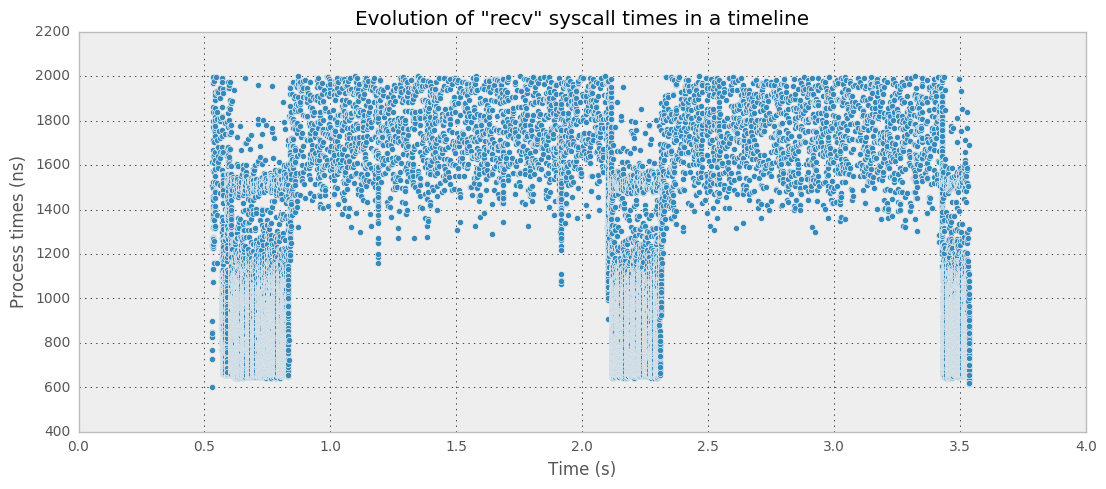

In [27]:
# Create a pandas dataframe starting from the tracepoint archives
# (converted into csv format)
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)
# Let's convert absolute timestamps into relative ones for convenience
df.nsecs -= df.nsecs.iloc[0]
# Let's use an internal function of linux-perf-stats to calculate
# delays between 2 dataframe rows; this function expects a column
# "nsecs" and will create a new column "duration"
df = lps.event_interval._add_intervals(df)
# Select:
# * Only the rows which corresponds to 2 contiguous
#   raw_syscalls:sys_enter events (or dataframe lines)
# * Only the delays below 2us so as to zoom on the interesting area
selection = \
    (df.event == 'raw_syscalls__sys_enter') & \
    (df.next_event == 'raw_syscalls__sys_enter') & \
    (df.comm == 'netserver') & \
    (df.duration < 2000)
df = df.loc[selection]
# Plot the result:
df['secs'] = df.nsecs / 1e9
plot = df.plot.scatter(x='secs', y='duration')
plot.set_title('Evolution of "recv" syscall times in a timeline')
plot.set_ylabel('Process times (ns)')
plot.set_xlabel('Time (s)')

What ??? There are still 2 modes here:

* An efficient mode where the syscall times are significantly below
  1us; and also it seems that most of the syscalls occur during this
  mode;
* A less efficient mode during which it seems there are fewer syscalls
  which last longer.

Here, we could propose an idea:

* If the NET_RX processing (more prioritary because executed in soft
  IRQ context) takes less times, there is more cycles left to the
  user-space application (netserver) which will perform more syscalls
  to empty the socket. So, the L1 instruction cache keeps the syscall
  code warm and its execution lasts shorter.

Let's compare in a unique diagram many rates so as to be sure such
an idea is worth something.

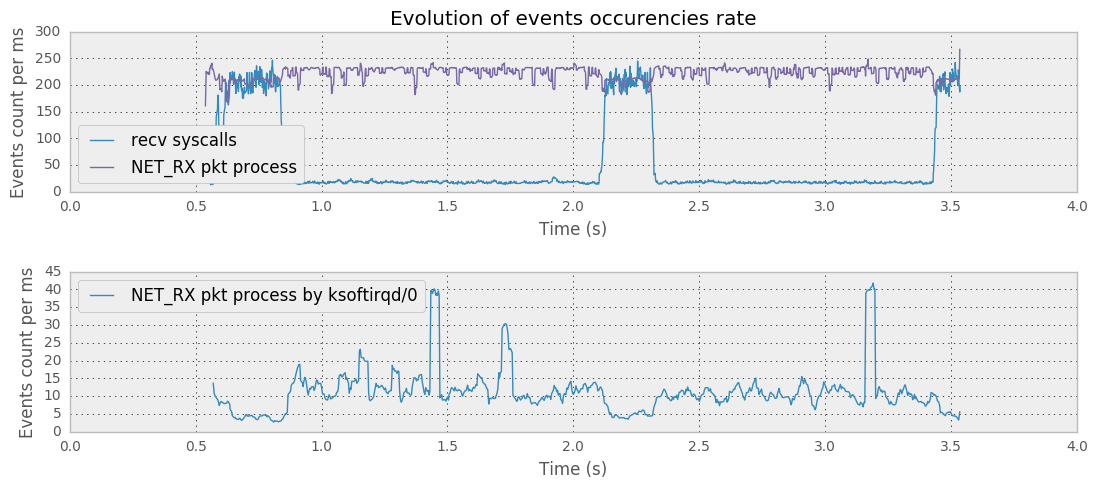

In [61]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)
df.nsecs -= df.nsecs.iloc[0]
df['msecs'] = (df.nsecs / 1e6).astype(int)

fig, plots = plt.subplots(2, 1)
plots = np.ndarray.flatten(plots)

selection = \
    (df.event == 'raw_syscalls__sys_enter') & \
    (df.comm == 'netserver')
df1 = df.loc[selection]
gp_df1 = df1.groupby('msecs').event.count()
gp_df1 = gp_df1.rolling(window=10, center=False).mean()
plots[0].plot(gp_df1.index / 1e3, gp_df1, label='recv syscalls')

selection = df.event == 'net__netif_receive_skb'
df2 = df.loc[selection]
gp_df2 = df2.groupby('msecs').event.count()
gp_df2 = gp_df2.rolling(window=10, center=False).mean()
plots[0].plot(gp_df2.index / 1e3, gp_df2, label='NET_RX pkt process')

selection = \
    (df.event == 'net__netif_receive_skb') & \
    (df.comm == 'ksoftirqd/0')
df3 = df.loc[selection]
gp_df3 = df3.groupby('msecs').event.count()
gp_df3 = gp_df3.rolling(window=10, center=False).mean()
plots[1].plot(gp_df3.index / 1e3, gp_df3, label='NET_RX pkt process by ksoftirqd/0')

for i in range(len(plots)):
    plots[i].set_ylabel('Events count per ms')
    plots[i].set_xlim(0, 4)
    plots[i].set_xlabel('Time (s)')

plots[0].set_title('Evolution of events occurencies rate')
plots[0].legend(loc=3)
plots[1].legend(loc=2)

The graphics above show 2 critical points:

* The user-application (netserver which reads packets) manages to keep
  up with the NET_RX incoming packets only during the "efficient"
  phases.
* During the efficient phases, ksoftirqd/0 is working far less; so
  efficient phases are not correlated with "high load soft IRQ"
  phases.

So, I still have only one hypothesis left to explain the 2 phases:

* There is some concurrency issue decreasing the performances of
  the NET_RX packet processing.

Along the NET_RX soft IRQ processing path, where could there be some
concurrency issue... on a UP (only 1 core) virtual machine ??? The
only place where some concurrency phenomenon could be observed is the
virtio interface; more precisely between the host OS which pushes data
into the virtio (maybe ring-buffer) and the guest core which pulls
data from the virtio device in the NET_RX soft IRQ handler. So, the
performance penalty may be explained by the scheduling of the thread
which pushes packets into the virtio device. The fact that the last
mode (at the end of the 3 seconds) is an efficient one (without any
concurrency issue) reinforces this hypothesis: at the end, there was
no more packet to send through the virtio device.

Let's stop here this remark; we are not here to analyze the virtio-net
interface; we are here to assess the kernel network reception
capacity. BUT, the performance penalty due to concurrency (which
reaches here at least 700ns) could also be observed on the other edge
of the NET_RX processing in a multi-core environment: when data are
pushed into the socket queue (and pulled by the syscall recvmsg).

# Conclusion

The first part of this study was an opportunity to learn how network
reception works in the Linux kernel and how the kernel interacts with
a user-space application which reads the incoming packets (via a bsd
socket). Network reception can be divided in 2 steps (with a NAPI
device or without if we skip interrupt handling):

* The soft IRQ NET_RX retrieves packets from the device RX-ring,
  parses them and routes them towards the proper socket (only UDP case
  of course);
* The user-space application triggers syscalls to empty the socket
  queue and to copy the payload into user-space.

Without any concurrency issue (or any other issue I was unable to
discover), the average time of a the NET_RX processing for 1 packet
should be below 1.5 us; that means that the Linux kernel can
600,000.00 packets per second per core running the NET_RX soft IRQ
routine.

If there is a concurrency issue (or any other problem), the average
value reaches at least 2us. The difference is significant enough to
try at later time to evaluate the cost of a concurrency issue located
in the socket queue (at the end of the NET_RX processing).

Many things were not handled here (packet size, core affinity in a
multi-core system). The second part will deal with them (or maybe the
third...).

# Annex A: Minor change in buildroot to enable perf's python script support

```
diff --git a/linux/linux-tool-perf.mk b/linux/linux-tool-perf.mk
index 8143474..b3cf86d 100644
--- a/linux/linux-tool-perf.mk
+++ b/linux/linux-tool-perf.mk
@@ -25,7 +25,6 @@ PERF_MAKE_FLAGS = \
        NO_NEWT=1 \
        NO_GTK2=1 \
        NO_LIBPERL=1 \
-       NO_LIBPYTHON=1 \
        NO_LIBBIONIC=1

 # We need to pass an argument to ld for setting the endianness when
@@ -88,6 +87,12 @@ else
 PERF_MAKE_FLAGS += NO_LZMA=1
 endif

+ifeq ($(BR2_PACKAGE_PYTHON),y)
+PERF_DEPENDENCIES += python
+else
+PERF_MAKE_FLAGS += NO_LIBPYTHON=1
+endif
+
 # We really do not want to build the perf documentation, because it
 # has stringent requirement on the documentation generation tools,
 # like xmlto and asciidoc), which may be lagging behind on some
@@ -129,6 +134,4 @@ endef
 define PERF_INSTALL_TARGET_CMDS
        $(TARGET_MAKE_ENV) $(MAKE1) $(PERF_MAKE_FLAGS) \
                -C $(@D)/tools/perf O=$(@D)/tools/perf/ install
-       $(RM) -rf $(TARGET_DIR)/usr/libexec/perf-core/scripts/
-       $(RM) -rf $(TARGET_DIR)/usr/libexec/perf-core/tests/
 endef
```

# Annex B: Some details on guest / host network configurations

In vm guest, manual commands to configure eth0:

```
# ip link set eth0 up
# ip addr add 192.168.2.2 dev eth0
# ip route add dev eth0 default
```

In host, manual commands to configure tap0 (the interface was created
by Qemu at init time, before launching the vm):

```
# ip link set tap0 up
# ip addr add 192.168.2.1 dev tap0
# ip route add 192.168.2.2/32 dev tap0
```

# Annex C: The perf command and the recorded tracepoints

Here is the perf command which records the selected tracepoints:

```
perf record \
    -e raw_syscalls:sys_enter \
    -e irq_vectors:call_function_entry \
    -e irq_vectors:call_function_exit \
    -e irq_vectors:call_function_single_entry \
    -e irq_vectors:call_function_single_exit \
    -e irq_vectors:deferred_error_apic_entry \
    -e irq_vectors:deferred_error_apic_exit \
    -e irq_vectors:error_apic_entry \
    -e irq_vectors:error_apic_exit \
    -e irq_vectors:local_timer_entry \
    -e irq_vectors:local_timer_exit \
    -e irq_vectors:reschedule_entry \
    -e irq_vectors:reschedule_exit \
    -e irq_vectors:spurious_apic_entry \
    -e irq_vectors:spurious_apic_exit \
    -e irq_vectors:thermal_apic_entry \
    -e irq_vectors:thermal_apic_exit \
    -e irq_vectors:threshold_apic_entry \
    -e irq_vectors:threshold_apic_exit \
    -e irq_vectors:x86_platform_ipi_entry \
    -e irq_vectors:x86_platform_ipi_exit \
    -e "irq:*" \
    -e "exceptions:*" \
    -e "sched:*" \
    -e net:netif_receive_skb \
    -e napi:napi_poll \
    -a -- sleep 4
```

And here is the perf command which converts the perf archive into a
csv file:

```
# perf script \
    -i /tmp/perf.data \
    -s xxx/linux-perf-stats/share/perf_python_scripts/export-to-csv.py \
    output=/tmp/recv_ms100.csv
```

Here is the list of recorded tracepoints:

In [147]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_ms100.csv'
df = pd.read_csv(fname)
df.event.unique()

array(['raw_syscalls__sys_enter', 'sched__sched_waking',
       'sched__sched_stat_runtime', 'sched__sched_wakeup',
       'sched__sched_switch', 'exceptions__page_fault_user',
       'exceptions__page_fault_kernel', 'sched__sched_process_exec',
       'irq_vectors__local_timer_entry', 'irq__softirq_raise',
       'irq_vectors__local_timer_exit', 'irq__softirq_entry',
       'irq__softirq_exit', 'irq__irq_handler_entry',
       'irq__irq_handler_exit', 'net__netif_receive_skb',
       'napi__napi_poll', 'sched__sched_migrate_task',
       'sched__sched_process_fork', 'sched__sched_wakeup_new',
       'sched__sched_process_exit'], dtype=object)

# Annex D: netperf's reception code in UDP_STREAM case

```
nettest_bsd.c:

void
recv_udp_stream()
{
...
  while (!times_up) {
    if(local_connected) {
       len = recv(s_data,
                  recv_ring->buffer_ptr,
                  message_size,
                  0);
    } else {
       len = recvfrom(s_data,
                      recv_ring->buffer_ptr,
    	              message_size,
		      0,0,0);
    }

    if (len != message_size) {
      if ((len == SOCKET_ERROR) && !SOCKET_EINTR(len)) {
            netperf_response.content.serv_errno = errno;
	    send_response();
	    exit(1);
      }
      break;
    }
    messages_recvd++;
    recv_ring = recv_ring->next;
   }
...
}
```

# Annex E: pre-requisite python import code

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import linux_perf_stats as lps

pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
lps.configure_plots()

-c:9: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

